In [110]:
import alpaca_trade_api as tradeapi
from street_cred import *
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [2]:
api = tradeapi.REST(keys, keys_to_the_vip, paper_products)

In [203]:
orders = api.get_activities('FILL', after="2022-02-14", until="2022-03-01")

In [194]:
dt.datetime.today().date().strftime('%Y-%m-%d')

'2022-03-01'

In [204]:
len(orders)

86

In [196]:
orders.reverse()
for order in orders:
    print(order.transaction_time)

2022-01-31 17:46:00.784080+00:00
2022-01-31 17:46:00.818815+00:00
2022-01-31 17:46:00.823592+00:00
2022-01-31 17:46:00.826455+00:00
2022-01-31 17:46:00.958109+00:00
2022-01-31 17:46:00.962798+00:00
2022-01-31 17:46:00.975131+00:00
2022-01-31 17:46:01.023676+00:00
2022-01-31 17:46:01.156592+00:00
2022-01-31 17:46:01.190502+00:00
2022-02-02 14:30:47.483534+00:00
2022-02-02 14:30:47.522676+00:00
2022-02-02 14:30:47.545892+00:00
2022-02-02 14:30:47.682172+00:00
2022-02-02 14:30:47.733525+00:00
2022-02-02 14:30:47.750417+00:00
2022-02-02 14:30:47.880831+00:00
2022-02-03 14:30:33.903426+00:00
2022-02-03 14:30:33.918760+00:00
2022-02-03 14:30:33.937889+00:00
2022-02-03 14:30:33.951320+00:00
2022-02-03 14:30:33.959409+00:00
2022-02-03 14:30:33.977296+00:00
2022-02-03 14:30:33.983177+00:00
2022-02-03 14:30:34.144729+00:00
2022-02-03 14:30:34.362463+00:00
2022-02-03 14:30:34.369189+00:00
2022-02-04 14:30:34.466353+00:00
2022-02-04 14:30:34.473740+00:00
2022-02-04 14:30:34.481737+00:00
2022-02-04

In [95]:
class Trade:
    def __init__(self, date, qty, status, side, price):
        self.date = date
        self.qty = qty 
        self.status = status
        self.side = side
        self.entry_price = price
        self.finish_flag = False
        if status == 'filled':
            self.close_flag = True
        else:
            self.close_flag = False

    def update_entry(self, qty, status, price):
        self.status = status
        prev_total = self.qty*self.entry_price
        new_total = qty*price
        self.qty = self.qty + qty
        self.entry_price = (new_total + prev_total) / self.qty
        if status == 'filled':
            self.close_flag = True

    def close_position(self, qty, status, price):
        self.exit_price = price
        self.exit_qty = qty
        self.exit_status = status
        if status == 'filled':
            self._check_win()
            self.finish_flag = True
    
    def update_close(self, qty, status, price):
        self.exit_status = status
        prev_total = self.exit_qty*self.exit_price
        new_total = qty*price
        self.exit_qty = self.exit_qty + qty
        self.exit_price (new_total + prev_total) / self.exit_qty
        if status == 'filled':
            self._check_win()
            self.finish_flag = True

    def _check_win(self):
        if self.side == 'sell_short':
            if self.entry_price > self.exit_price:
                self.win = 1
            else:
                self.win = 0
        else:
            if self.entry_price < self.exit_price:
                self.win = 1
            else:
                self.win = 0
    
    def to_sample(self, symbol):
        sample = []
        sample.append(self.date)
        sample.append(symbol)
        sample.append(self.entry_price)
        sample.append(self.side)
        sample.append(self.win)

        return sample


In [96]:
orders[0].transaction_time.date()

datetime.date(2022, 2, 10)

In [197]:
active_orders = {}
samples = []
for order in orders:
    if order.symbol not in active_orders.keys() and order.side == 'sell':
        continue
    
    if order.symbol not in active_orders.keys():
        active_orders[order.symbol] = Trade(order.transaction_time.date(), int(order.qty), order.order_status, order.side, float(order.price))
    elif active_orders[order.symbol].status == 'partially_filled':
        active_orders[order.symbol].update_entry(int(order.qty), order.order_status, float(order.price))
    elif active_orders[order.symbol].close_flag:
        active_orders[order.symbol].close_position(int(order.qty), order.order_status, float(order.price))
    elif active_orders[order.symbol].close_flag and active_orders[order.symbol].exit_status == 'partially_filled':
        active_orders[order.symbol].update_close(int(order.qty), order.order_status, float(order.price))
    
    if active_orders[order.symbol].finish_flag == True:
        samples.append(active_orders[order.symbol].to_sample(order.symbol))
        del active_orders[order.symbol]

samples
    

[[datetime.date(2022, 1, 31), 'TRV', 165.68, 'buy', 1],
 [datetime.date(2022, 1, 31), 'TQQQ', 60.16, 'sell_short', 0],
 [datetime.date(2022, 1, 31), 'HYG', 84.41, 'buy', 1],
 [datetime.date(2022, 2, 2), 'SE', 156.52, 'sell_short', 1],
 [datetime.date(2022, 1, 31), 'SQQQ', 38.54, 'buy', 1],
 [datetime.date(2022, 2, 2), 'PG', 160.48, 'buy', 1],
 [datetime.date(2022, 2, 2), 'KO', 60.85, 'buy', 1],
 [datetime.date(2022, 2, 3), 'CRM', 215.64, 'buy', 1],
 [datetime.date(2022, 2, 3), 'GOOG', 2904.23, 'sell_short', 1],
 [datetime.date(2022, 2, 3), 'SMH', 275.56, 'sell_short', 1],
 [datetime.date(2022, 2, 3), 'PYPL', 129.26, 'buy', 0],
 [datetime.date(2022, 2, 3), 'TQQQ', 59.05, 'sell_short', 1],
 [datetime.date(2022, 2, 4), 'UNH', 482.9, 'sell_short', 0],
 [datetime.date(2022, 1, 31), 'MA', 382.65, 'buy', 0],
 [datetime.date(2022, 2, 7), 'GS', 366.52, 'sell_short', 0],
 [datetime.date(2022, 2, 7), 'AMZN', 3157.92, 'sell_short', 1],
 [datetime.date(2022, 2, 4), 'FB', 235.93, 'buy', 0],
 [dateti

In [198]:
columns = ['date', 'symbol', 'price', 'side', 'win']
df = pd.DataFrame(data=samples, columns=columns)

In [199]:
df

,date,symbol,price,side,win
0,2022-01-31,TRV,165.680000,buy,1
1,2022-01-31,TQQQ,60.160000,sell_short,0
2,2022-01-31,HYG,84.410000,buy,1
3,2022-02-02,SE,156.520000,sell_short,1
4,2022-01-31,SQQQ,38.540000,buy,1
5,2022-02-02,PG,160.480000,buy,1
6,2022-02-02,KO,60.850000,buy,1
7,2022-02-03,CRM,215.640000,buy,1
8,2022-02-03,GOOG,2904.230000,sell_short,1
9,2022-02-03,SMH,275.560000,sell_short,1


In [200]:
samples = []
for i, row in df.iterrows():
    start_date = row['date'] - dt.timedelta(days=7)
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = row['date'].strftime('%Y-%m-%d')
    stock_df = yf.Ticker(row['symbol']).history(start=start_date, end=end_date)
    max_val = stock_df['High'].max()
    min_val = stock_df['Low'].min()
    med_val = min_val + (max_val - min_val)/2
    max_val = max_val / med_val
    min_val = min_val / med_val
    price = row['price'] / med_val
    if row['side'] == 'buy':
        side = 1
    else:
        side = 0
    samples.append([min_val, max_val, price, side, row['win']])


In [201]:
columns = ['week_low', 'week_high', 'price', 'side', 'win']
final_df = pd.DataFrame(samples, columns=columns)
final_df

,week_low,week_high,price,side,win
0,0.968258,1.031742,0.996961,1,1
1,0.900206,1.099794,1.124276,0,0
2,0.988694,1.011306,0.997704,1,1
3,0.857153,1.142847,1.123537,0,1
4,0.902909,1.097091,0.879407,1,1
5,0.984358,1.015642,1.010166,1,1
6,0.981679,1.018321,1.013491,1,1
7,0.946988,1.053012,0.968363,1,1
8,0.916645,1.083355,1.034290,0,1
9,0.934983,1.065017,1.033221,0,1


In [202]:
past_df = pd.read_csv("trade_history.csv")
final_df = pd.concat([past_df, final_df])
final_df.to_csv("trade_history.csv", index=False)

In [115]:
X = final_df[['week_low', 'week_high', 'price', 'side']]
y = final_df['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [124]:
weights = {1:1, 0:1}
model = LogisticRegression(random_state=42, class_weight=weights).fit(X_train, y_train)

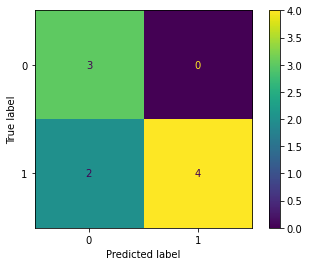

In [125]:
plot_confusion_matrix(model, X_test, y_test)
#plt.show()